<a href="https://colab.research.google.com/github/Chelodromo/ast1_co18_carreras_maudet_mas/blob/main/Prophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install numpy==1.26.0

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
    status = run_func(*args)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/req_command.py", line 67, in wrapper
^C


In [ ]:
!pip install tensorflow numpy

In [ ]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 19.2 MB/s eta 0:00:00


In [1]:
# Librerías básicas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

# El módulo Statsmodels

Statsmodels es un módulo de Python que ofrece clases y funciones de varios modelos estadísticos, así como pruebas de hipótesis
y análisis exploratorio de datos. La documentación se encuentra en <a href='https://www.statsmodels.org/stable/index.html'>statsmodels.org</a>.

In [2]:
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.seasonal import seasonal_decompose

import statsmodels.graphics.tsaplots as sgt
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy.stats.distributions import chi2
import statsmodels.tsa.stattools as sts

# Fuentes de datos interesantes

## API de Yahoo finance

Yahoo Finance tiene una API que permite descargar información financiera para realizar análisis. La página web original de la documentación ya no existe. Sin embargo, existen algunas páginas de documentación no oficial como <a href= 'https://github.com/mxbi/yahoo-finance-api.git'> este repositorio en GitHub, </a> o <a href='https://python-yahoofinance.readthedocs.io/en/latest/api.html'> esta página de documentación the ReadTheDocs </a>.

In [3]:
# Instalación de yfinance
%pip install yfinance

In [4]:
# Se importa la librería yfinance
import yfinance

In [5]:
stcok_1= "BDORY"
close_1="close_BDORY"
stcok_2="^BVSP"
close_2="close_BVSP"
fecha_inicial= "2024-05-31"
fecha_final = "2025-05-31"

In [6]:
# Se descargan los datos Banco do Brasil y
df_yfinance_raw = yfinance.download(tickers = (stcok_1 ,stcok_2 ), #Las series de tiempo de interés -
                              start = fecha_inicial, #Fecha inicial
                              end = fecha_final, #Fecha final
                              interval = "1d", #Frecuencia.
                              group_by = 'ticker', #Criterio de agrupación. Usualmente "ticker"
                              auto_adjust = True#,
                              #threads = True
                               ) #.

[*********************100%***********************]  2 of 2 completed


In [7]:
df_yfinance_raw.head()

Ticker         BDORY                                             ^BVSP  \
Price           Open      High       Low     Close    Volume      Open   
Date                                                                     
2024-05-31  4.968457  4.987530  4.873093  4.977993  744500.0  122704.0   
2024-06-03  4.939848  5.044748  4.892166  4.892166  774400.0  122100.0   
2024-06-04  4.911238  4.977993  4.901702  4.930311  128300.0  122032.0   
2024-06-05  4.920775  5.054285  4.911239  4.949384  284900.0  121803.0   
2024-06-06  4.968457  5.073357  4.968457  5.073357   92900.0  121408.0   

Ticker                                                
Price           High       Low     Close      Volume  
Date                                                  
2024-05-31  122837.0  121929.0  122098.0  15918600.0  
2024-06-03  122495.0  121496.0  122032.0   8428100.0  
2024-06-04  122032.0  120878.0  121802.0   8529300.0  
2024-06-05  122170.0  121253.0  121407.0   8768700.0  
2024-06-06  123246.0  121377.0  122899.0   8404200.0

In [8]:
# Se crea una copia para modificar
df_yfinance = df_yfinance_raw.copy()

In [9]:
# Se agregan columnas para el nivel de cierre
df_yfinance[close_1] = df_yfinance[stcok_1].Close
df_yfinance[close_2] = df_yfinance[stcok_2].Close

In [10]:
#f_comp = df_comp.iloc[1:] # Removing the first elements, since we always start 1 period before the first, due to time zone differences of closing prices
del df_yfinance[stcok_1] # Se retiran los grupos de columnas
del df_yfinance[stcok_2]
df_yfinance=df_yfinance.asfreq('b') # Se establece la frecuencia de los datos
df_yfinance=df_yfinance.fillna(method='ffill') # Se rellenan los datos faltantes con el método ffill que usa el último valor válido

<ipython-input-10-1360112101>:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_yfinance=df_yfinance.fillna(method='ffill') # Se rellenan los datos faltantes con el método ffill que usa el último valor válido


In [11]:
df_yfinance.head()

Ticker,close_BDORY,close_BVSP
Price,,
Date,,
2024-05-31,4.977993,122098.0
2024-06-03,4.892166,122032.0
2024-06-04,4.930311,121802.0
2024-06-05,4.949384,121407.0
2024-06-06,5.073357,122899.0


In [12]:
df_yfinance.columns

MultiIndex([('close_BDORY', ''),
            ( 'close_BVSP', '')],
           names=['Ticker', 'Price'])

In [13]:
df_yfinance.columns=[close_1,close_2]

In [14]:
df_yfinance.columns

Index(['close_BDORY', 'close_BVSP'], dtype='object')

In [15]:
df_yfinance.head()

,close_BDORY,close_BVSP
Date,,
2024-05-31,4.977993,122098.0
2024-06-03,4.892166,122032.0
2024-06-04,4.930311,121802.0
2024-06-05,4.949384,121407.0
2024-06-06,5.073357,122899.0


In [16]:
df_yfinance.columns

Index(['close_BDORY', 'close_BVSP'], dtype='object')

In [17]:
df_yfinance.index = pd.to_datetime(df_yfinance.index)

In [18]:
df_yfinance.tail() # Making sure of the last day we're including in the series

,close_BDORY,close_BVSP
Date,,
2025-05-26,4.42,138136.0
2025-05-27,4.54,139541.0
2025-05-28,4.31,138888.0
2025-05-29,4.26,138534.0
2025-05-30,4.15,137027.0


In [25]:
#df_comp.date = pd.to_datetime(df_comp.date, dayfirst = True)
#df_comp.set_index("date", inplace=True)
df_yfinance=df_yfinance.asfreq('b')
df_yfinance=df_yfinance.fillna(method='ffill')

<ipython-input-25-1293345636>:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_yfinance=df_yfinance.fillna(method='ffill')


In [24]:
df_yfinance.head()

,close_BDORY,close_BVSP
Date,,
2024-05-31,4.977993,122098.0
2024-06-03,4.892166,122032.0
2024-06-04,4.930311,121802.0
2024-06-05,4.949384,121407.0
2024-06-06,5.073357,122899.0


#Medir ESTACIONARIDAD

In [29]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from IPython.display import display

# Cargar vista previa para verificar contenido


# Medir estacionaridad con prueba ADF para las dos primeras columnas
col1, col2 = df_yfinance.columns[:2]

adf_result_1 = adfuller(df_yfinance[col1].dropna())
adf_result_2 = adfuller(df_yfinance[col2].dropna())

# Crear DataFrame resumen
adf_summary = pd.DataFrame({
    'Serie': [col1, col2],
    'ADF Statistic': [adf_result_1[0], adf_result_2[0]],
    'p-value': [adf_result_1[1], adf_result_2[1]],
    'Stationary (p<0.05)': [adf_result_1[1] < 0.05, adf_result_2[1] < 0.05]
})

display(adf_summary)



,Serie,ADF Statistic,p-value,Stationary (p<0.05)
0,close_BDORY,-2.301686,0.171425,False
1,close_BVSP,-1.671621,0.445790,False


CON P

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import grangercausalitytests
import numpy as np

In [31]:

# Establecer 'fecha' como índice
#f_yfinance.set_index('Date', inplace=True)

# Calcular retornos diarios
close_1_ret = df_yfinance[close_1].pct_change().dropna()
close_2_ret = df_yfinance[close_2].pct_change().dropna()

# Empalmar retornos
df_retornos = pd.concat([close_1_ret, close_2_ret], axis=1).dropna()
df_retornos.columns = [close_1, close_2]

# Granger: ¿close_1 causa a close_2?
resultado_granger_close_1_close_2 = grangercausalitytests(df_retornos[[close_2, close_1]], maxlag=5, verbose=False)
pvalues_close_1_causa = [round(resultado_granger_close_1_close_2[i+1][0]['ssr_ftest'][1], 4) for i in range(5)]

# Granger: ¿close_2 causa a close_1?
resultado_granger_close_2_close_1 = grangercausalitytests(df_retornos[[close_1, close_2]], maxlag=5, verbose=False)
pvalues_close_2_causa = [round(resultado_granger_close_2_close_1[i+1][0]['ssr_ftest'][1], 4) for i in range(5)]

# Crear tabla comparativa
granger_df = pd.DataFrame({
    'lag': range(1, 6),
    f'{close_1} → {close_2} (p-value)': pvalues_close_1_causa,
    f'{close_2} → {close_1} (p-value)': pvalues_close_2_causa
})

display(granger_df)


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


,lag,close_BDORY → close_BVSP (p-value),close_BVSP → close_BDORY (p-value)
0,1,0.7829,0.0962
1,2,0.6324,0.0460
2,3,0.3525,0.1003
3,4,0.4760,0.1796
4,5,0.4408,0.0313


Qué mide el test de Granger

Columna close_1 → close_2: mide si los movimientos de close_1 ayudan a predecir close_2.

Columna close_2 → close_1 mide si los movimientos de close_2 ayudan a predecir close_1.

En los casos en los que p-values sean altos (>> 0.05), no hay evidencia estadísticamente significativa de causalidad directa en ninguno de los sentidos.

df_retornos[[Y, X]] verifica si X → Y

Un p-value bajo (<< 0.05) indica que hay evidencia estadística para rechazar la hipótesis nula: la serie X no causa Granger a la serie Y.

En el test de Granger, la hipótesis nula es que “X no causa Granger a Y”.

Un p < 0.05 se interpreta como evidencia suficiente para rechazar la hipótesis nula, lo cual sugiere que X sí causa Granger a Y.


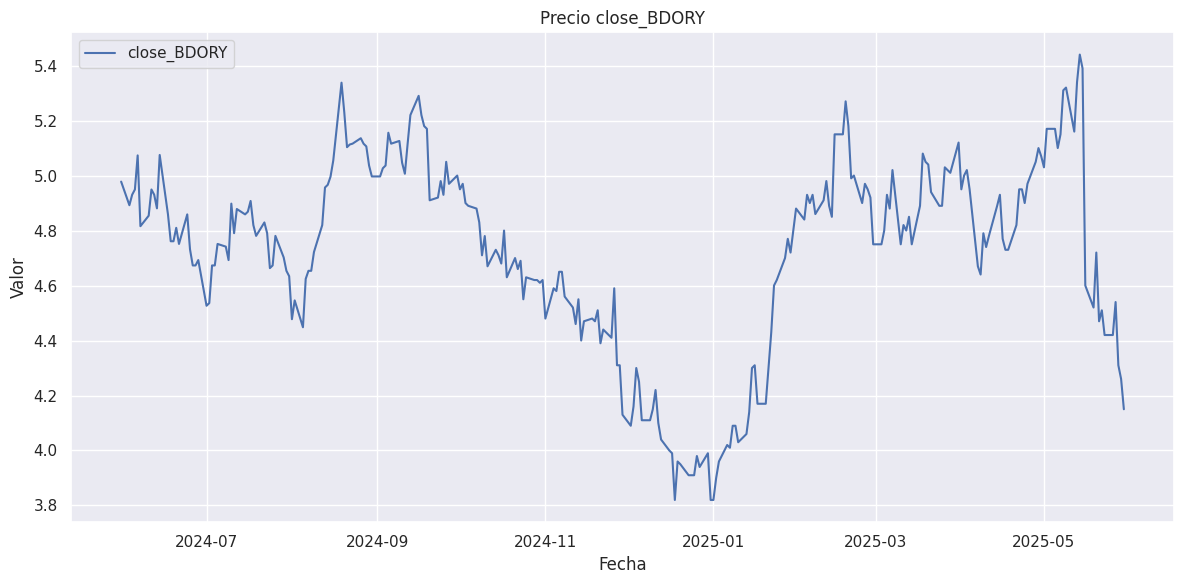

In [32]:
# Graficar las series originales de close_BDORY
plt.figure(figsize=(12, 6))
plt.plot(df_yfinance.index, df_yfinance[close_1], label=close_1)
plt.title(f"Precio {close_1}")
plt.xlabel("Fecha")
plt.ylabel("Valor")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


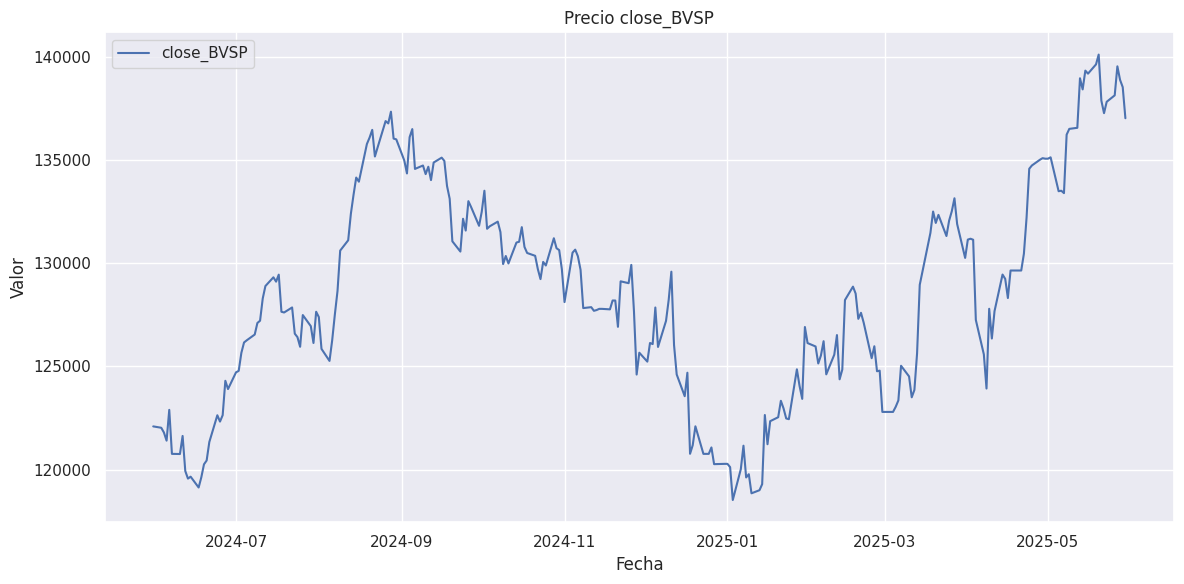

In [ ]:
# Graficar las series originales de close_BVSP
plt.figure(figsize=(12, 6))
plt.plot(df_yfinance.index, df_yfinance[close_2], label=close_2)
plt.title(f"Precio {close_2}")
plt.xlabel("Fecha")
plt.ylabel("Valor")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
df_yfinance.index = pd.to_datetime(df_yfinance.index).tz_localize(None)

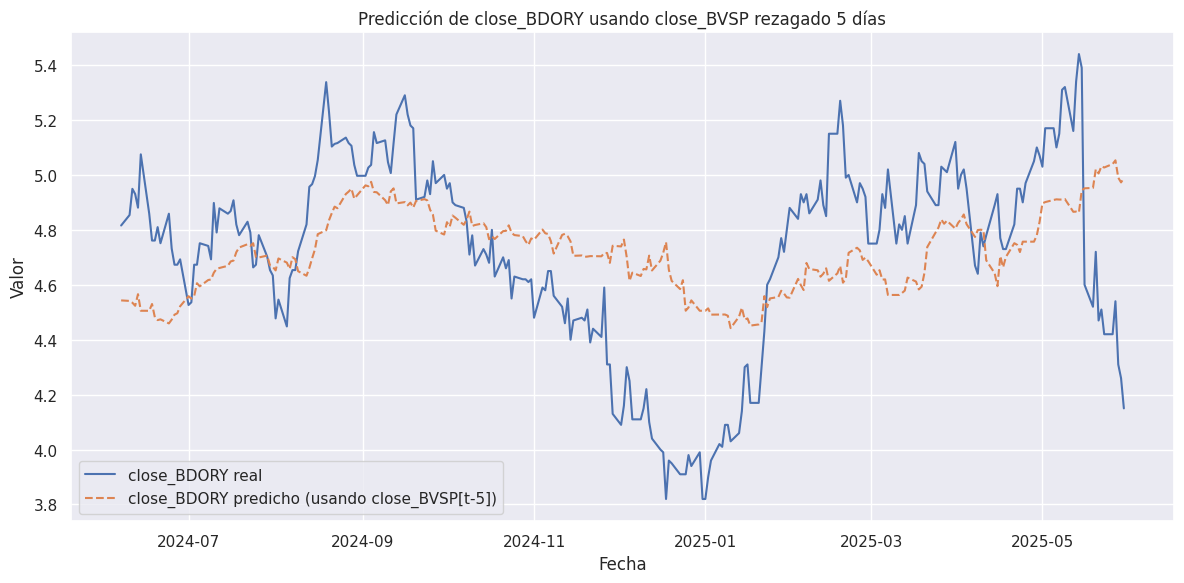

In [ ]:
from sklearn.linear_model import LinearRegression

# Suponiendo que ya tenés df con columnas: close_1 y close_2
# Y que estas variables están definidas
lag = 5

# Crear variables X ( t-5) y y ( t)

# Crear copia del dataframe con la variable rezagada
df_modelo = df_yfinance.copy()
df_modelo[f'{close_2}_lag{lag}'] = df_modelo[close_2].shift(lag)

# Eliminar valores nulos (por el shift)
df_modelo = df_modelo[[close_1, f'{close_2}_lag{lag}']].dropna()

# Definir variables X e y
X = df_modelo[[f'{close_2}_lag{lag}']]
y = df_modelo[close_1]

# Ajustar modelo de regresión
modelo = LinearRegression()
modelo.fit(X, y)

# Generar predicciones
df_modelo['predicho'] = modelo.predict(X)

# Graficar
plt.figure(figsize=(12,6))
plt.plot(df_modelo.index, df_modelo[close_1], label=f'{close_1} real')
plt.plot(df_modelo.index, df_modelo['predicho'], label=f'{close_1} predicho (usando {close_2}[t-{lag}])', linestyle='--')
plt.title(f'Predicción de {close_1} usando {close_2} rezagado {lag} días')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
!pip install pmdarima

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

,close_BDORY_real,close_BDORY_predicha
fecha,,
2024-06-28,4.692638,4.869624
2024-07-01,4.526440,4.863166
2024-07-02,4.536216,4.863648
2024-07-03,4.673086,4.841884
2024-07-04,4.673086,4.816161
...,...,...
2025-05-26,4.420000,5.198000
2025-05-27,4.540000,5.005563
2025-05-28,4.310000,4.930599


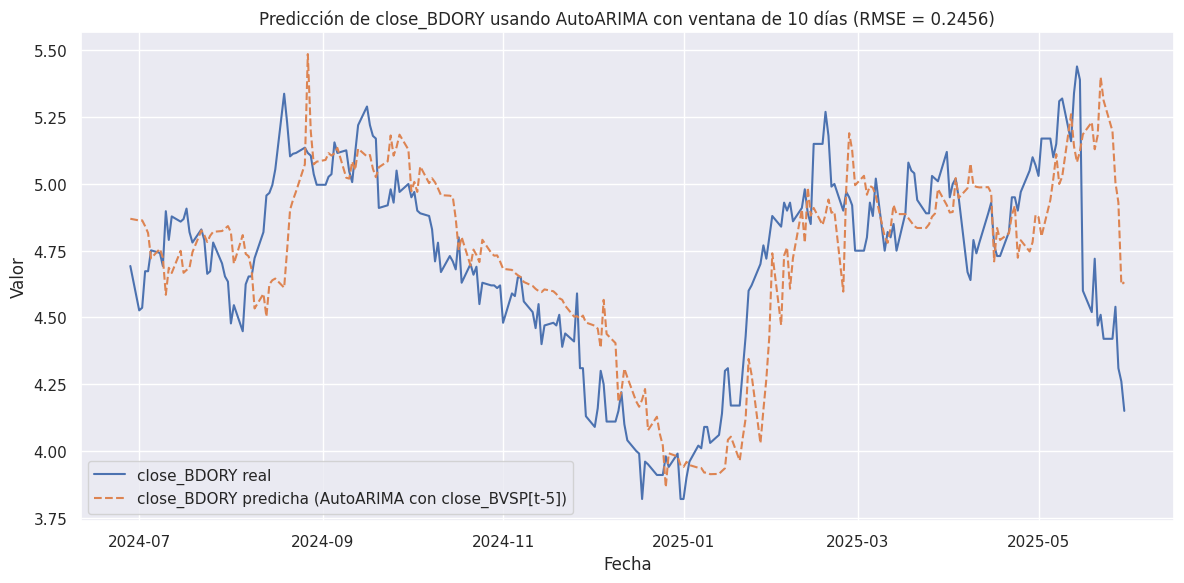

In [ ]:
from sklearn.metrics import mean_squared_error
from pmdarima.arima import auto_arima
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Variables configurables
window_size = 10
lag = 5

# Crear copia para no modificar el original
df_model = df_yfinance.copy()

# Crear columna con el rezago de close_2
df_model[f'{close_2}_lag{lag}'] = df_model[close_2].shift(lag)

# Inicializar listas para resultados
predicciones = []
valores_reales = []
fechas = []

# Loop con ventana deslizante
for i in range(window_size + lag, len(df_model)):
    ventana = df_model.iloc[i - window_size - lag:i - lag]

    # Validación de NaN
    if ventana[f'{close_2}_lag{lag}'].isnull().any() or ventana[close_1].isnull().any():
        continue

    try:
        # Entrenar modelo ARIMA con variable exógena rezagada
        modelo = auto_arima(
            ventana[close_1],
            exogenous=ventana[[f'{close_2}_lag{lag}']],
            suppress_warnings=True,
            error_action='ignore'
        )

        # Predicción para el tiempo i
        exog_pred = df_model[[f'{close_2}_lag{lag}']].iloc[i:i+1]
        pred = modelo.predict(n_periods=1, exogenous=exog_pred)[0]

        # Guardar resultados
        predicciones.append(pred)
        valores_reales.append(df_model[close_1].iloc[i])
        fechas.append(df_model.index[i])

    except:
        continue

# Crear DataFrame de resultados
df_resultado = pd.DataFrame({
    'fecha': fechas,
    f'{close_1}_real': valores_reales,
    f'{close_1}_predicha': predicciones
}).set_index('fecha')

# Display the resulting DataFrame before calculating RMSE
display(df_resultado)

# Calcular RMSE
rmse = np.sqrt(mean_squared_error(df_resultado[f'{close_1}_real'], df_resultado[f'{close_1}_predicha']))

# Graficar
plt.figure(figsize=(12, 6))
plt.plot(df_resultado.index, df_resultado[f'{close_1}_real'], label=f'{close_1} real')
plt.plot(df_resultado.index, df_resultado[f'{close_1}_predicha'], label=f'{close_1} predicha (AutoARIMA con {close_2}[t-{lag}])', linestyle='--')
plt.title(f'Predicción de {close_1} usando AutoARIMA con ventana de {window_size} días (RMSE = {rmse:.4f})')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Librería AutoARIMA

In [ ]:
%pip install pmdarima

In [ ]:
from pmdarima.arima import auto_arima

# Yahoo finance

In [ ]:
yfinance_auto_model = auto_arima(df_yfinance[close_1])

In [ ]:
yfinance_auto_model

ARIMA(order=(0, 1, 1), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [ ]:
yfinance_auto_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  261
Model:               SARIMAX(0, 1, 1)   Log Likelihood                 208.249
Date:                Mon, 16 Jun 2025   AIC                           -412.499
Time:                        12:13:19   BIC                           -405.377
Sample:                    05-31-2024   HQIC                          -409.636
                         - 05-30-2025                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.1420      0.055     -2.577      0.010      -0.250      -0.034
sigma2         0.0118      0.000     28.135      0.000       0.011       0.013
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):              1185.38
Prob(Q):                              0.85   Prob(JB):                         0.00
Heteroskedasticity (H):               2.18   Skew:                            -1.53
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
yfinance_auto_results = yfinance_auto_model.fit(df_yfinance[close_1])

In [ ]:
yfinance_auto_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  261
Model:               SARIMAX(0, 1, 1)   Log Likelihood                 208.249
Date:                Mon, 16 Jun 2025   AIC                           -412.499
Time:                        12:13:25   BIC                           -405.377
Sample:                    05-31-2024   HQIC                          -409.636
                         - 05-30-2025                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.1420      0.055     -2.577      0.010      -0.250      -0.034
sigma2         0.0118      0.000     28.135      0.000       0.011       0.013
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):              1185.38
Prob(Q):                              0.85   Prob(JB):                         0.00
Heteroskedasticity (H):               2.18   Skew:                            -1.53
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

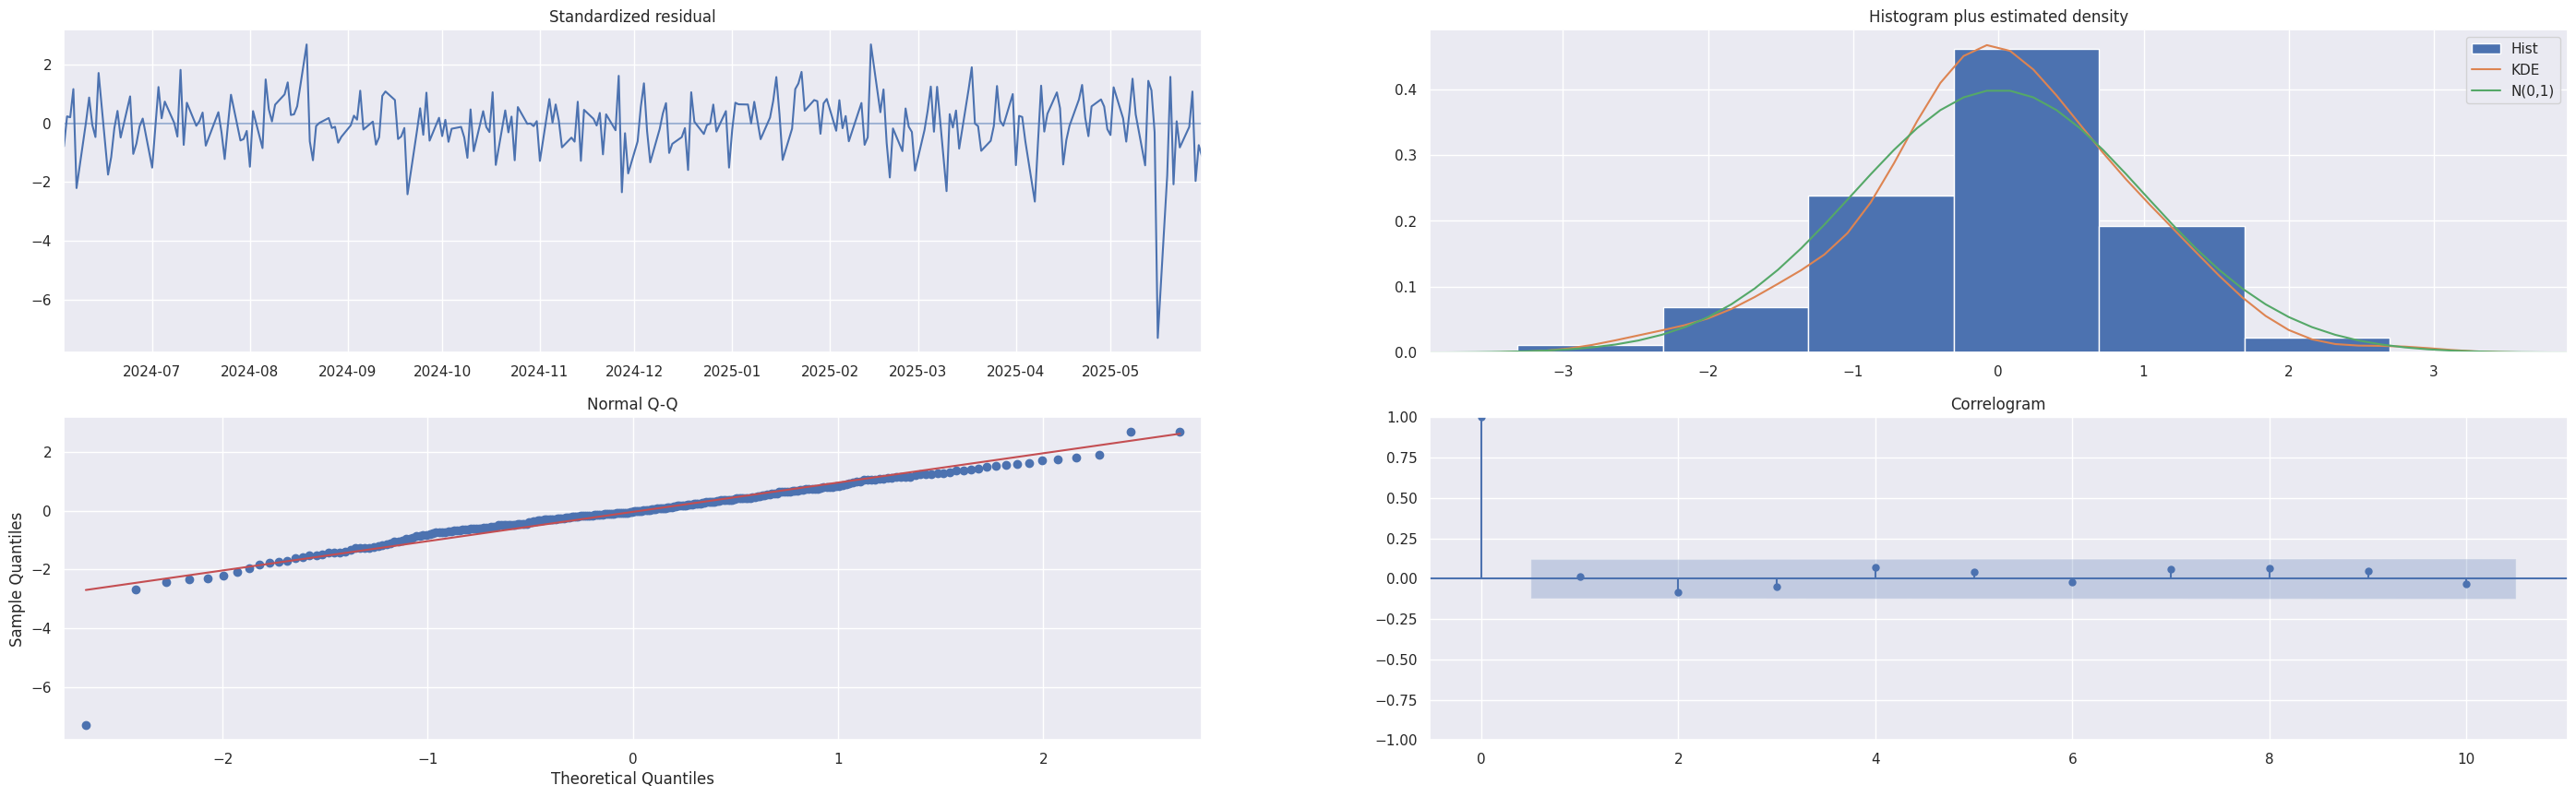

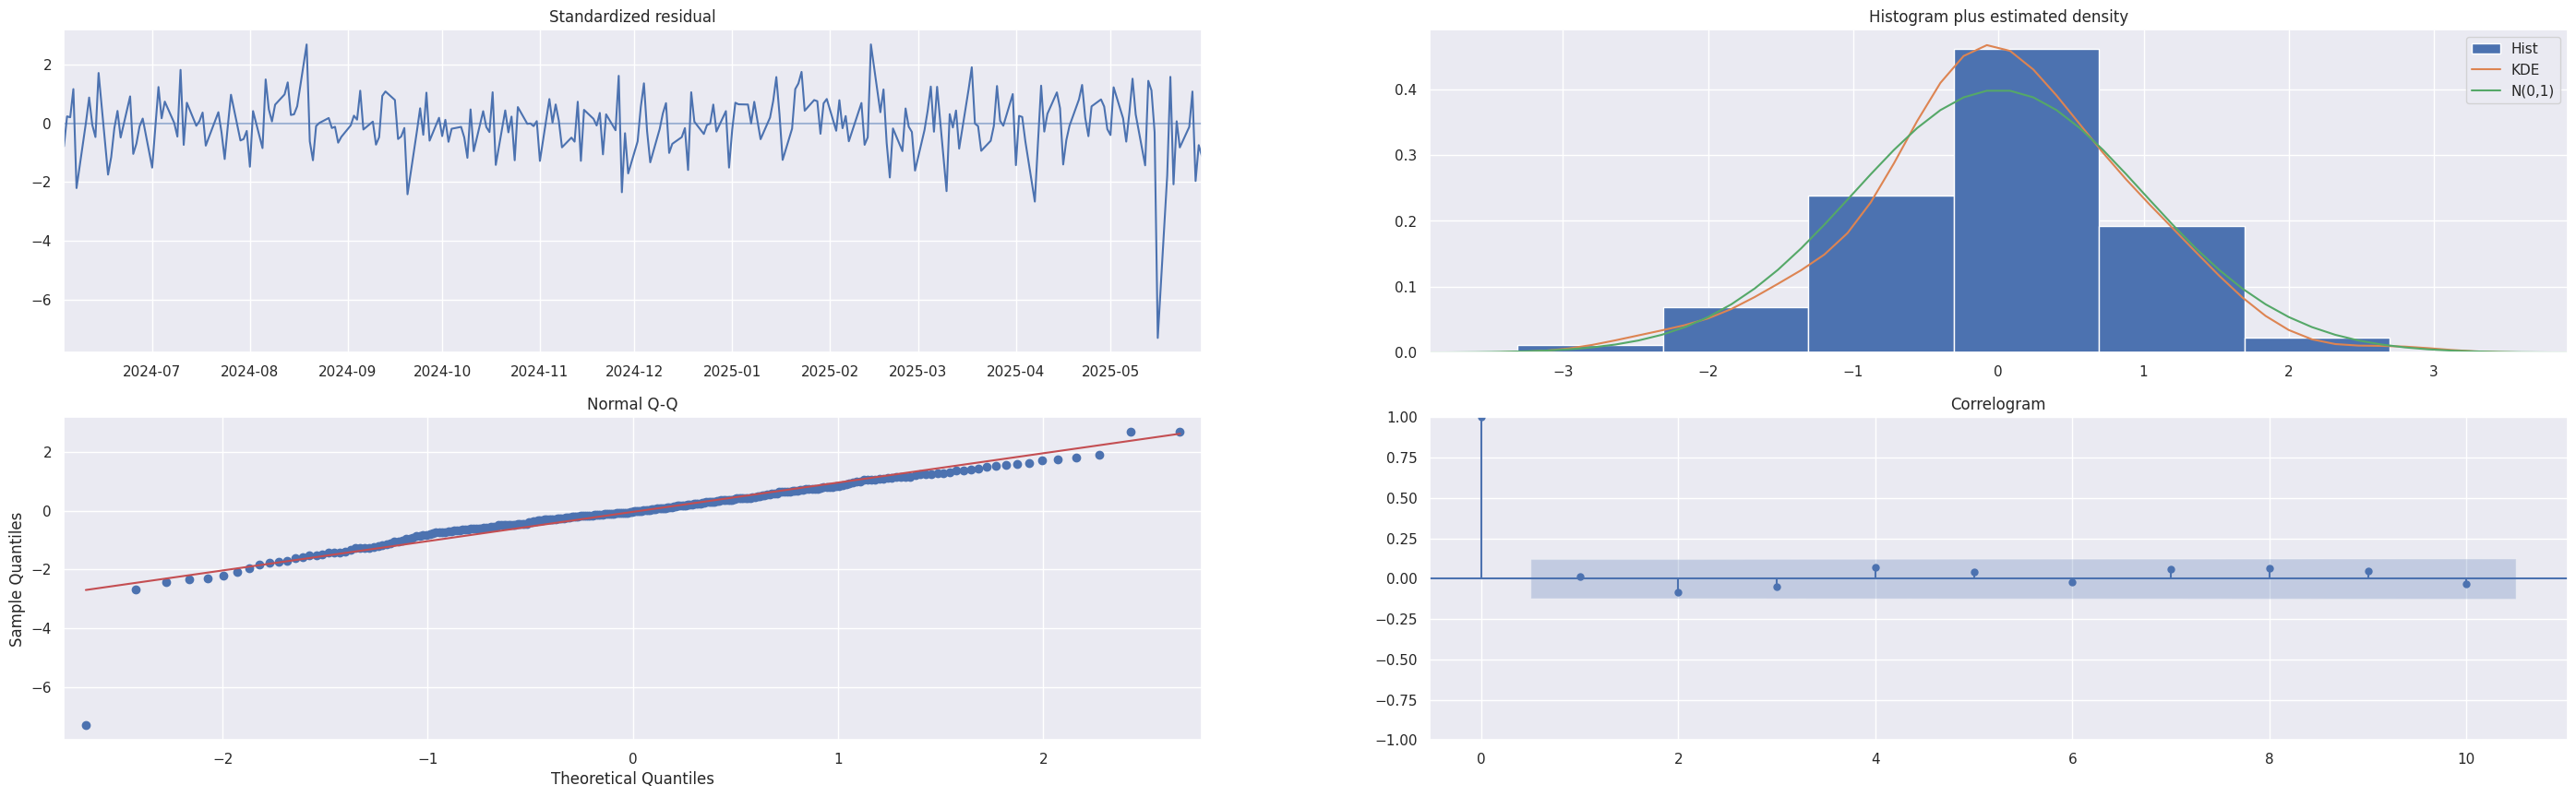

In [ ]:
yfinance_auto_model.plot_diagnostics(figsize=(35,10))

In [ ]:
df_yfinance['AutoModel'] =yfinance_auto_results.predict_in_sample(n_periods=len(df_yfinance))

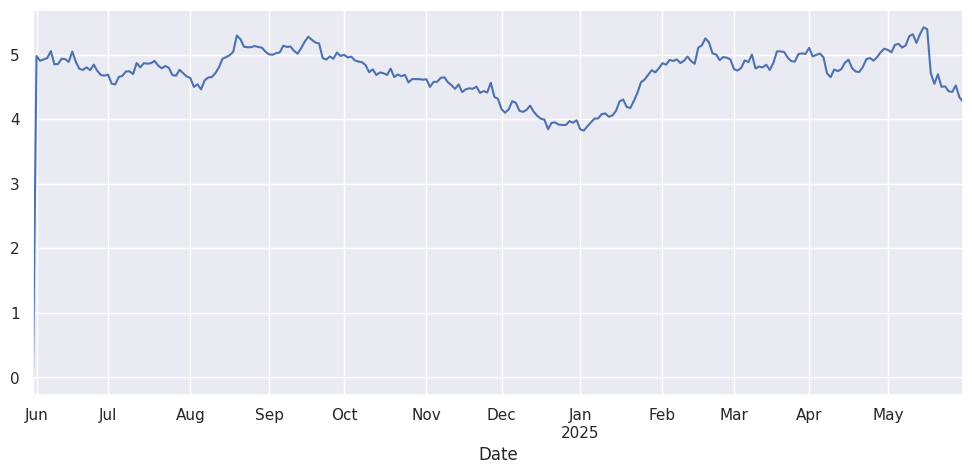

In [ ]:
df_yfinance['AutoModel'].plot(figsize=(12,5));

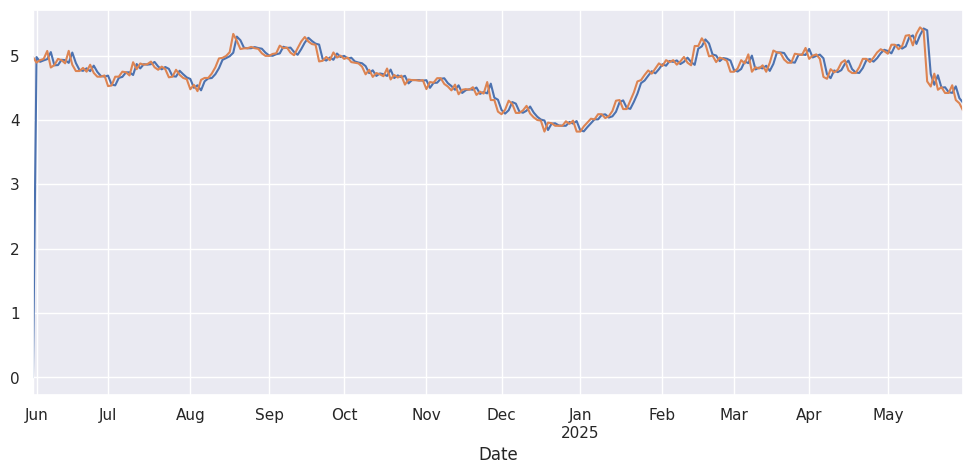

In [ ]:
yfinance_auto_results.predict_in_sample(n_periods=len(df_yfinance)).plot()
df_yfinance[close_1].plot(figsize=(12,5));

In [ ]:
# Obtener los valores predichos y reales
valores_predichos = df_yfinance['AutoModel']
valores_reales = df_yfinance[close_1]

# Alinear las fechas (opcional: asegurar intersección si hay desalineación)
fechas_comunes = valores_reales.index.intersection(valores_predichos.index)

# Crear tabla de comparación
df_tabla = pd.DataFrame({
    f'{close_1}_real': valores_reales.loc[fechas_comunes],
    f'{close_1}_predicho': valores_predichos.loc[fechas_comunes]
}, index=fechas_comunes)

# Mostrar primeras filas como tabla simple
print(df_tabla.head(10))


            close_BDORY_real  close_BDORY_predicho
Date                                              
2024-05-31          4.977993              0.000000
2024-06-03          4.892166              4.977993
2024-06-04          4.930311              4.904110
2024-06-05          4.949384              4.926593
2024-06-06          5.073357              4.946148
2024-06-07          4.815876              5.055297
2024-06-10          4.854020              4.849867
2024-06-11          4.949384              4.853430
2024-06-12          4.930311              4.935761
2024-06-13          4.880824              4.931085


<Axes: xlabel='Date'>

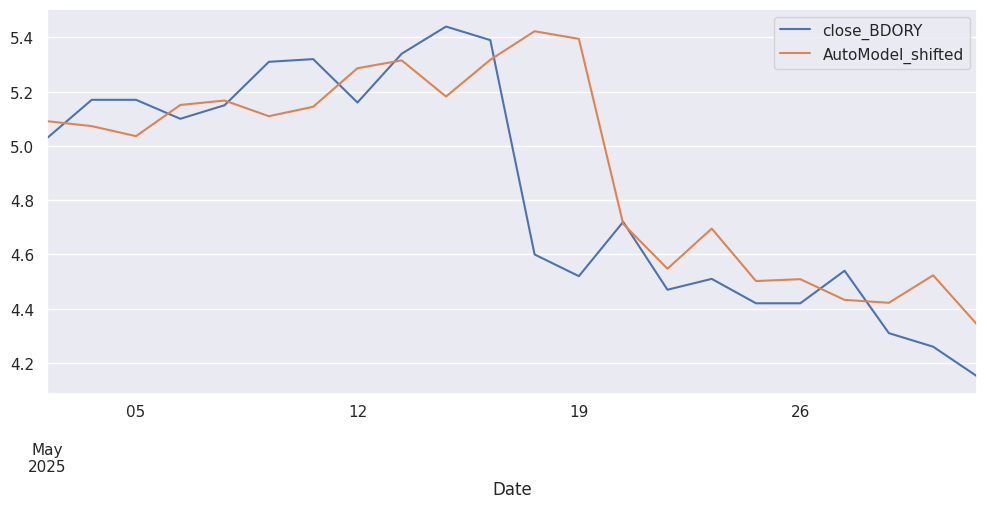

In [ ]:
# df_yfinance[[close_1,'AutoModel']]['2025-05-01':'2025-05-30'].plot(figsize=(12,5));
df_yfinance['AutoModel_shifted'] = df_yfinance['AutoModel'].shift(1)
df_yfinance[[close_1, 'AutoModel_shifted']]['2025-05-01':'2025-05-30'].plot(figsize=(12, 5))


In [ ]:
serie = df_yfinance[close_1]
split_point = int(len(serie) * 0.8)
train_data = serie[:split_point]
test_data = serie[split_point:]


In [ ]:
len(test_data)

53

In [ ]:
#from pmdarima.arima import auto_arima

history = list(train_data)
predictions = []

for t in range(len(test_data)):
    model = auto_arima(history, suppress_warnings=True, error_action='ignore')
    pred = model.predict(n_periods=1)[0]
    predictions.append(pred)
    history.append(test_data.iloc[t])  # expandimos ventana con valor real



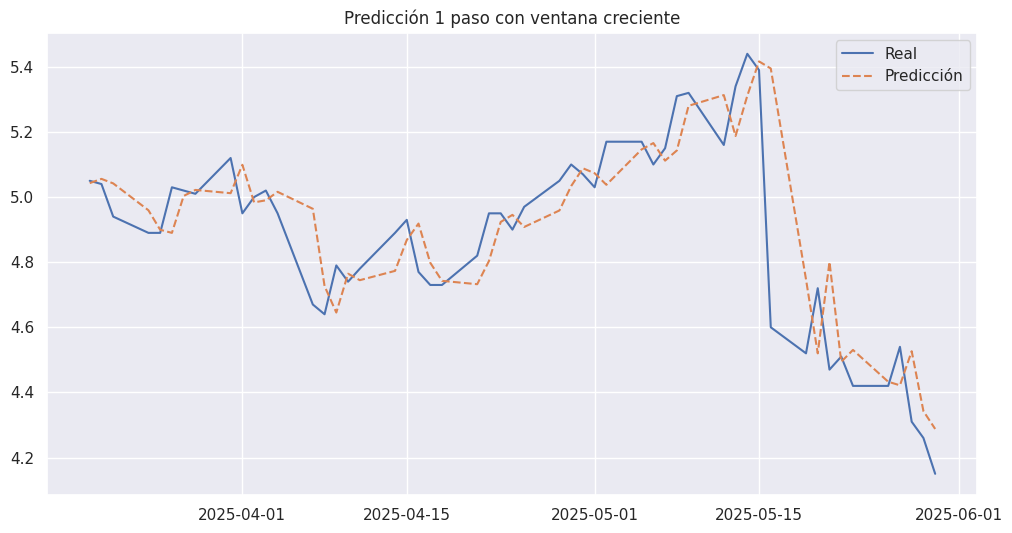

In [ ]:
import matplotlib.pyplot as plt

# Crear serie de predicciones alineadas con test
test_index = test_data.index
pred_series = pd.Series(predictions, index=test_index)

# Gráfico comparativo
plt.figure(figsize=(12,6))
plt.plot(test_data, label='Real')
plt.plot(pred_series, label='Predicción', linestyle='--')
plt.legend()
plt.title('Predicción 1 paso con ventana creciente')
plt.show()


In [ ]:
step = 5
for t in range(0, len(test_data) - step, step):
    model = auto_arima(history, suppress_warnings=True, error_action='ignore')
    pred = model.predict(n_periods=step)
    predictions.extend(pred)
    history.extend(test_data.iloc[t:t+step])



In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(test_data, pred_series)
mae = mean_absolute_error(test_data, pred_series)

print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")


MSE: 0.0252
MAE: 0.1037


#MODELO auto ARIMA con variable exogena rezagada.

,close_BDORY_real,close_BDORY_predicha
fecha,,
2024-06-28,4.692638,4.869624
2024-07-01,4.526440,4.863166
2024-07-02,4.536216,4.863648
2024-07-03,4.673086,4.841884
2024-07-04,4.673086,4.816161
...,...,...
2025-05-26,4.420000,5.198000
2025-05-27,4.540000,5.005563
2025-05-28,4.310000,4.930599


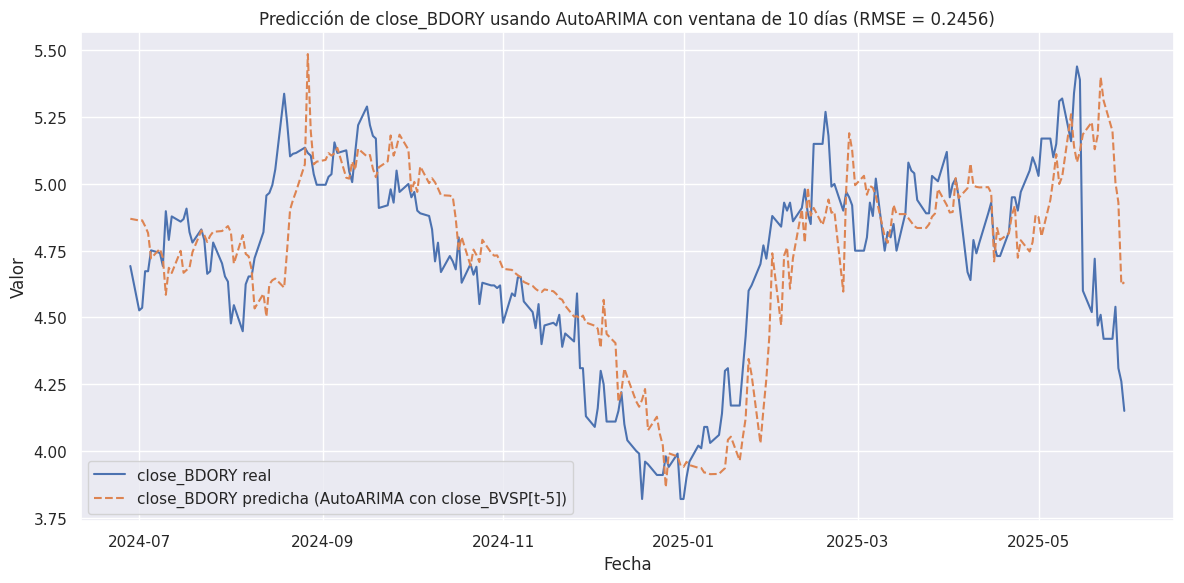

In [ ]:
#from sklearn.metrics import mean_squared_error
#from pmdarima.arima import auto_arima
#import numpy as np
#import matplotlib.pyplot as plt
#import pandas as pd

# Variables configurables
window_size = 10
lag = 5

# Crear copia para no modificar el original
df_model = df_yfinance.copy()

# Crear columna con el rezago de close_2
df_model[f'{close_2}_lag{lag}'] = df_model[close_2].shift(lag)

# Inicializar listas para resultados
predicciones = []
valores_reales = []
fechas = []

# Loop con ventana deslizante
for i in range(window_size + lag, len(df_model)):
    ventana = df_model.iloc[i - window_size - lag:i - lag]

    # Validación de NaN
    if ventana[f'{close_2}_lag{lag}'].isnull().any() or ventana[close_1].isnull().any():
        continue

    try:
        # Entrenar modelo ARIMA con variable exógena rezagada
        modelo = auto_arima(
            ventana[close_1],
            exogenous=ventana[[f'{close_2}_lag{lag}']],
            suppress_warnings=True,
            error_action='ignore'
        )

        # Predicción para el tiempo i
        exog_pred = df_model[[f'{close_2}_lag{lag}']].iloc[i:i+1]
        pred = modelo.predict(n_periods=1, exogenous=exog_pred)[0]

        # Guardar resultados
        predicciones.append(pred)
        valores_reales.append(df_model[close_1].iloc[i])
        fechas.append(df_model.index[i])

    except:
        continue

# Crear DataFrame de resultados
df_resultado = pd.DataFrame({
    'fecha': fechas,
    f'{close_1}_real': valores_reales,
    f'{close_1}_predicha': predicciones
}).set_index('fecha')

# Display the resulting DataFrame before calculating RMSE
display(df_resultado)

# Calcular RMSE
rmse = np.sqrt(mean_squared_error(df_resultado[f'{close_1}_real'], df_resultado[f'{close_1}_predicha']))

# Graficar
plt.figure(figsize=(12, 6))
plt.plot(df_resultado.index, df_resultado[f'{close_1}_real'], label=f'{close_1} real')
plt.plot(df_resultado.index, df_resultado[f'{close_1}_predicha'], label=f'{close_1} predicha (AutoARIMA con {close_2}[t-{lag}])', linestyle='--')
plt.title(f'Predicción de {close_1} usando AutoARIMA con ventana de {window_size} días (RMSE = {rmse:.4f})')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
df_resultado.head()

,close_BDORY_real,close_BDORY_predicha
fecha,,
2024-06-28,4.692638,4.869624
2024-07-01,4.526440,4.863166
2024-07-02,4.536216,4.863648
2024-07-03,4.673086,4.841884
2024-07-04,4.673086,4.816161


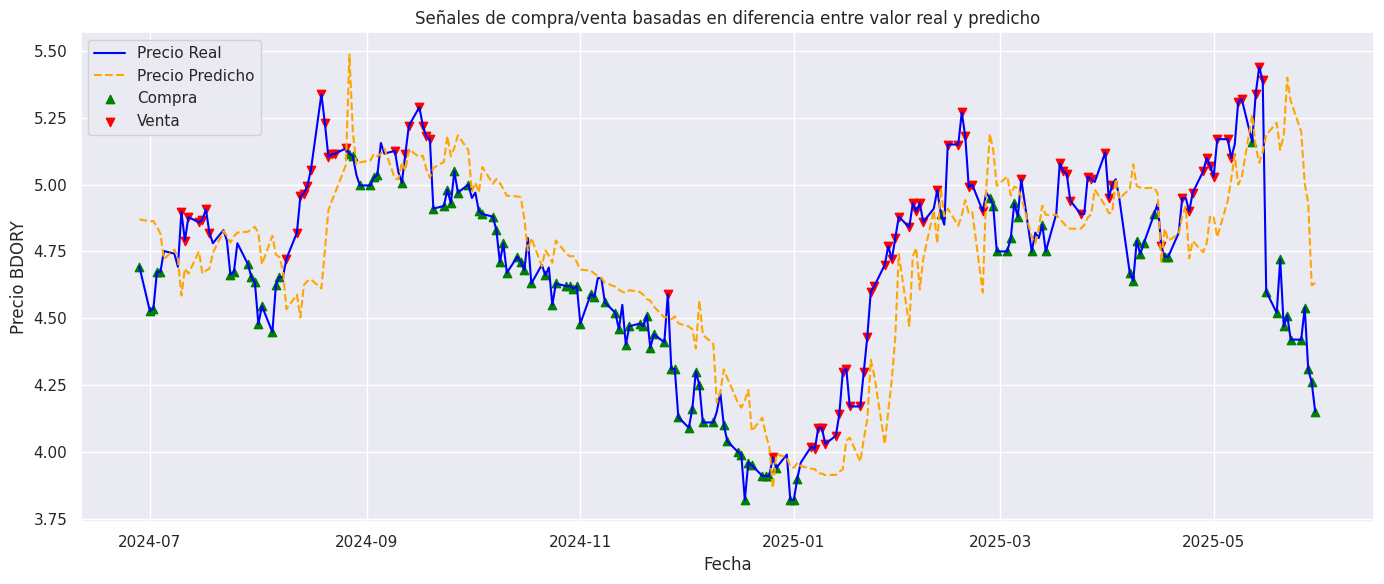

,close_BDORY_real,close_BDORY_predicha,diff,accion
fecha,,,,
2024-06-28,4.692638,4.869624,-0.176986,comprar
2024-07-01,4.526440,4.863166,-0.336726,comprar
2024-07-02,4.536216,4.863648,-0.327431,comprar
2024-07-03,4.673086,4.841884,-0.168798,comprar
2024-07-04,4.673086,4.816161,-0.143075,comprar
...,...,...,...,...
2025-05-26,4.420000,5.198000,-0.778000,comprar
2025-05-27,4.540000,5.005563,-0.465563,comprar
2025-05-28,4.310000,4.930599,-0.620599,comprar


In [ ]:
df = df_resultado
# df.set_index("fecha", inplace=True) # Remove this line as 'fecha' is already the index

# Estrategia de señal de compra/venta basada en el cruce entre real y predicho
df["diff"] = df[f'{close_1}_real'] - df[f'{close_1}_predicha']
df["signal"] = 0
df.loc[df["diff"] < -0.05, "signal"] = 1   # Señal de compra: precio real muy por debajo del predicho
df.loc[df["diff"] > 0.05, "signal"] = -1   # Señal de venta: precio real muy por encima del predicho

# Crear columna de acción: compra, venta, mantener
df["accion"] = df["signal"].map({1: "comprar", -1: "vender", 0: "mantener"})

# Mostrar las primeras señales encontradas
df_signals = df[df["signal"] != 0][[f'{close_1}_real', f'{close_1}_predicha', "diff", "accion"]]

# Graficar con señales
plt.figure(figsize=(14, 6))
plt.plot(df.index, df[f'{close_1}_real'], label="Precio Real", color="blue")
plt.plot(df.index, df[f'{close_1}_predicha'], label="Precio Predicho", color="orange", linestyle="--")
plt.scatter(df[df["signal"] == 1].index, df[df["signal"] == 1][f'{close_1}_real'], label="Compra", marker="^", color="green")
plt.scatter(df[df["signal"] == -1].index, df[df["signal"] == -1][f'{close_1}_real'], label="Venta", marker="v", color="red")
plt.legend()
plt.title("Señales de compra/venta basadas en diferencia entre valor real y predicho")
plt.xlabel("Fecha")
plt.ylabel("Precio BDORY")
plt.grid(True)
plt.tight_layout()
plt.show()

#from IPython.display import display

display(df_signals)

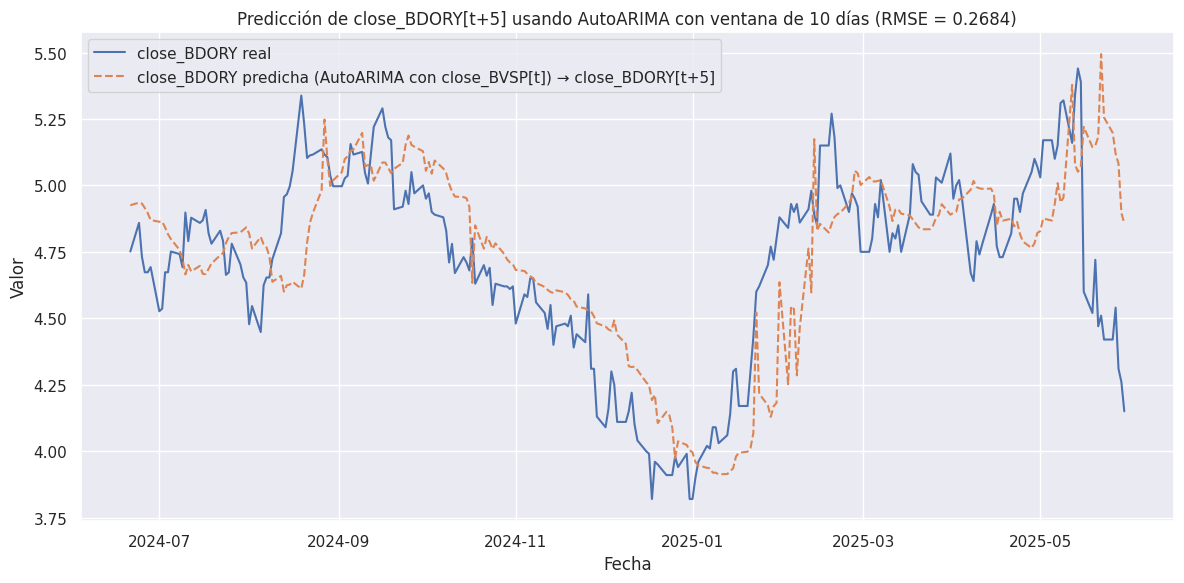

In [ ]:
# Versión modificada del código: predice close_1[t+5] usando close_2[t]
#from pmdarima.arima import auto_arima
#from sklearn.metrics import mean_squared_error
#import numpy as np
#import pandas as pd
#import matplotlib.pyplot as plt

# Variables configurables
window_size = 10
forecast_horizon = 5  # predicción a t+5

# Crear copia para no modificar el original
df_model = df_yfinance.copy()

# Inicializar listas para resultados
predicciones = []
valores_reales = []
fechas = []

# Loop con ventana deslizante para predecir t+5 usando datos hasta t
for i in range(window_size, len(df_model) - forecast_horizon):
    ventana = df_model.iloc[i - window_size:i]

    # Extraer exógeno actual (t) para predecir t+5
    exog_pred = df_model[[close_2]].iloc[i:i+1].values

    # Validación de NaN
    if ventana[close_1].isnull().any() or ventana[close_2].isnull().any() or np.isnan(exog_pred).any():
        continue

    try:
        # Entrenar modelo ARIMA con variable exógena (hasta t)
        modelo = auto_arima(
            ventana[close_1],
            exogenous=ventana[[close_2]],
            suppress_warnings=True,
            error_action='ignore'
        )

        # Predecir para t+5 usando exógeno de t repetido forecast_horizon veces
        pred = modelo.predict(n_periods=forecast_horizon, exogenous=np.repeat(exog_pred, forecast_horizon, axis=0))[-1]

        # Guardar resultados
        predicciones.append(pred)
        valores_reales.append(df_model[close_1].iloc[i + forecast_horizon])
        fechas.append(df_model.index[i + forecast_horizon])

    except:
        continue

# Crear DataFrame de resultados
df_resultado = pd.DataFrame({
    'fecha': fechas,
    f'{close_1}_real': valores_reales,
    f'{close_1}_predicha': predicciones
}).set_index('fecha')

# Calcular RMSE
rmse = np.sqrt(mean_squared_error(df_resultado[f'{close_1}_real'], df_resultado[f'{close_1}_predicha']))

# Graficar
plt.figure(figsize=(12, 6))
plt.plot(df_resultado.index, df_resultado[f'{close_1}_real'], label=f'{close_1} real')
plt.plot(df_resultado.index, df_resultado[f'{close_1}_predicha'], label=f'{close_1} predicha (AutoARIMA con {close_2}[t]) → {close_1}[t+{forecast_horizon}]', linestyle='--')
plt.title(f'Predicción de {close_1}[t+{forecast_horizon}] usando AutoARIMA con ventana de {window_size} días (RMSE = {rmse:.4f})')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


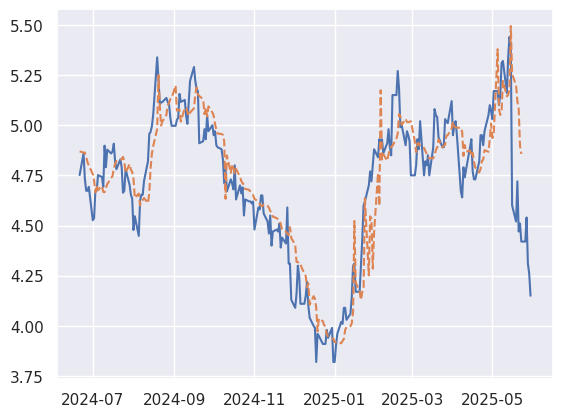

In [ ]:
df_resultado[f'{close_1}_predicha_shifted'] = df_resultado[f'{close_1}_predicha'].shift(-5)
plt.plot(df_resultado.index, df_resultado[f'{close_1}_real'], label='Real')
plt.plot(df_resultado.index, df_resultado[f'{close_1}_predicha_shifted'], label='Predicha en t para t+5', linestyle='--')


In [ ]:
import pandas as pd

# Calcular retornos diarios
close_1_ret = df_yfinance[close_1].pct_change().dropna()
close_2_ret = df_yfinance[close_2].pct_change().dropna()

# Empalmar retornos alineados
df_retornos = pd.concat([close_1_ret, close_2_ret], axis=1).dropna()
df_retornos.columns = [close_1, close_2]

# Calcular correlación cruzada con lags de -5 a +5
lags = range(-5, 6)
correlaciones = []

for lag in lags:
    if lag < 0:
        corr = df_retornos[close_1].corr(df_retornos[close_2].shift(-lag))
    else:
        corr = df_retornos[close_1].shift(lag).corr(df_retornos[close_2])
    correlaciones.append(round(corr, 4))

# Crear DataFrame con resultados
correlacion_df = pd.DataFrame({
    'lag': lags,
    f'Corr({close_1}, {close_2})': correlaciones
})

# Mostrar tabla
display(correlacion_df)


,lag,"Corr(close_BDORY, close_BVSP)"
0,-5,-0.0991
1,-4,0.0071
2,-3,-0.0635
3,-2,0.0493
4,-1,0.0429
5,0,0.4122
6,1,-0.0071
7,2,-0.0589
8,3,0.0992
9,4,-0.0082


Para cada lag en [-5, +5]:

Compara el retorno de close_1 con el retorno de close_2 desplazado.

Si lag > 0: close_1 se compara con el pasado de close_2.

Si lag < 0: close_1 se compara con el futuro de close_2.

Lag positivo: close_2 podría causar o preceder a close_1.

Lag negativo: close_1 podría liderar a close_2.

El lag con mayor correlación absoluta puede sugerir liderazgo temporal.

Epoch 1/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.2535
Epoch 2/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0283
Epoch 3/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0255
Epoch 4/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0317
Epoch 5/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0268
Epoch 6/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0226
Epoch 7/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0301
Epoch 8/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0252
Epoch 9/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0251
Epoch 10/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0270
Epoch 11/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0227
Epoch 12/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0219
Epoch 13/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0244
Epoch 14/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0224
Epoch 15/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0232
Epoch 16/25
3

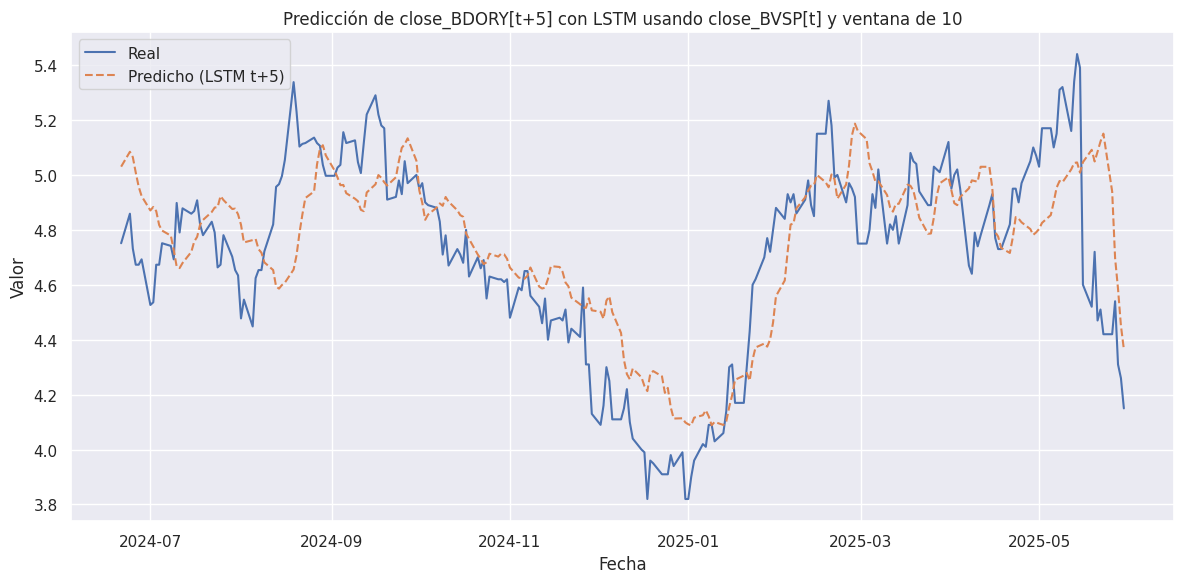

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Concatenate, Input
from tensorflow.keras.models import Model

# Parámetros configurables
window_size = 10
forecast_horizon = 5


# Preprocesamiento
df = df_yfinance

# Escalado
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df)
scaled_df = pd.DataFrame(scaled, columns=[close_1, close_2], index=df.index)

# Preparar secuencias para LSTM
X_seq, X_exog, y, fechas = [], [], [], []

for i in range(window_size, len(scaled_df) - forecast_horizon):
    X_seq.append(scaled_df[close_1].iloc[i - window_size:i].values.reshape(-1, 1))  # ventana histórica de close_1
    X_exog.append(scaled_df[close_2].iloc[i])  # valor actual de close_2
    y.append(scaled_df[close_1].iloc[i + forecast_horizon])  # valor futuro de close_1
    fechas.append(df.index[i + forecast_horizon])

X_seq = np.array(X_seq)  # (n_samples, window_size, 1)
X_exog = np.array(X_exog).reshape(-1, 1)  # (n_samples, 1)
y = np.array(y).reshape(-1, 1)

# Modelo LSTM con input dual: secuencia + exógeno
input_seq = Input(shape=(window_size, 1))
input_exog = Input(shape=(1,))
x = LSTM(50)(input_seq)
x = Concatenate()([x, input_exog])
output = Dense(1)(x)
model = Model(inputs=[input_seq, input_exog], outputs=output)

model.compile(optimizer='adam', loss='mse')
model.fit([X_seq, X_exog], y, epochs=25, batch_size=8, verbose=1)

# Predicción
y_pred_scaled = model.predict([X_seq, X_exog])
# Reescalamos
y_pred = scaler.inverse_transform(np.hstack((y_pred_scaled, np.zeros_like(y_pred_scaled))))[:, 0]
y_true = scaler.inverse_transform(np.hstack((y, np.zeros_like(y))))[:, 0]

# Resultados
df_resultado = pd.DataFrame({
    'fecha': fechas,
    f'{close_1}_real': y_true,
    f'{close_1}_predicha': y_pred
}).set_index('fecha')

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print(f'RMSE: {rmse:.4f}')

# Graficar
plt.figure(figsize=(12, 6))
plt.plot(df_resultado.index, df_resultado[f'{close_1}_real'], label='Real')
plt.plot(df_resultado.index, df_resultado[f'{close_1}_predicha'], label='Predicho (LSTM t+5)', linestyle='--')
plt.title(f'Predicción de {close_1}[t+5] con LSTM usando {close_2}[t] y ventana de {window_size}')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Modelo Prophet

Probamos ahora hacer las predicciones con el modelo Prophet de Meta

In [ ]:
!pip install prophet


Importamos las libreria necesarias

In [34]:
import pandas as pd
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

Hacemos una preparacion de los datos disponibles teniendo en cuenta los valores de cierre del banco do brasil y del  indice iBOBESPA valor que usaremos como regresor, tomamos los datos ya tratatos anteriormente, los dividimos en dataset de entrenamiento y de test, eligiendo un 85% de datos para el entrenamiento y luegos el ultimo 15% para hacer el test.

In [19]:
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1. Prepara tu DataFrame original (como df_prophet_multi)
df_prophet = df_yfinance[['close_BDORY', 'close_BVSP']].dropna().copy()
df_prophet = df_prophet.reset_index().rename(columns={'Date': 'ds', 'close_BDORY': 'y', 'close_BVSP': 'bvsp'})

In [20]:
# 2. Divide los datos: 85 % entrenamiento, 15 % prueba
cutoff = int(len(df_prophet) * 0.85)
df_train = df_prophet.iloc[:cutoff]
df_test = df_prophet.iloc[cutoff:]

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyou2z0bv/ur4seaxz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyou2z0bv/wghc13ey.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90021', 'data', 'file=/tmp/tmpyou2z0bv/ur4seaxz.json', 'init=/tmp/tmpyou2z0bv/wghc13ey.json', 'output', 'file=/tmp/tmpyou2z0bv/prophet_modelvf_9bl0d/prophet_model-20250618110220.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:02:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:02:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


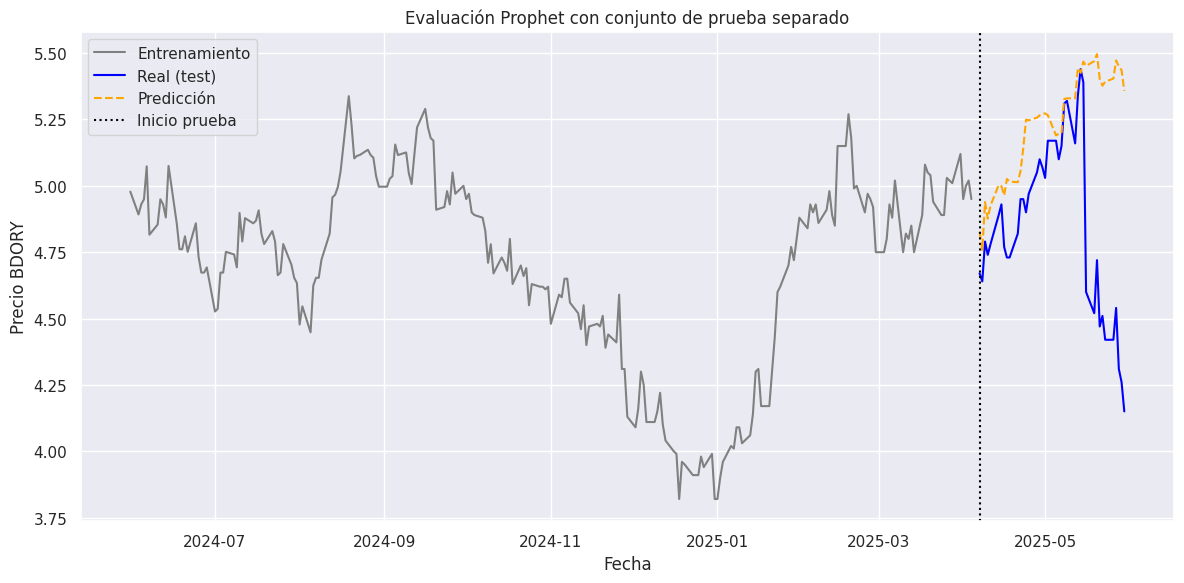

Métricas sobre el conjunto de prueba:
• MAE: 0.3760
• RMSE: 0.5391
• MAPE: 8.26%
• R² Score: -1.7869


,ds,y,bvsp
256,2025-05-26,4.42,138136.0
257,2025-05-27,4.54,139541.0
258,2025-05-28,4.31,138888.0
259,2025-05-29,4.26,138534.0
260,2025-05-30,4.15,137027.0


In [21]:


# 3. Entrena el modelo Prophet usando solo entrenamiento
model = Prophet()
model.add_regressor('bvsp')
model.fit(df_train)

# 4. Prepara el dataframe "future" solo con las fechas y regresores del test
future = df_test[['ds', 'bvsp']].copy()

# 5. Predicción sobre el conjunto de prueba
forecast = model.predict(future)

# 6. Calcula métricas de evaluación
y_true = df_test['y'].values
y_pred = forecast['yhat'].values

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
# MAPE seguro
mape = np.mean(np.abs((y_true - y_pred) / np.where(y_true == 0, 1e-3, y_true))) * 100
r2 = r2_score(y_true, y_pred)

# 7. Grafica comparativa
plt.figure(figsize=(12, 6))
plt.plot(df_train['ds'], df_train['y'], label='Entrenamiento', color='gray')
plt.plot(df_test['ds'], y_true, label='Real (test)', color='blue')
plt.plot(forecast['ds'], y_pred, label='Predicción', linestyle='--', color='orange')
plt.axvline(df_test['ds'].iloc[0], color='black', linestyle=':', label='Inicio prueba')
plt.title('Evaluación Prophet con conjunto de prueba separado')
plt.xlabel('Fecha')
plt.ylabel('Precio BDORY')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 8. Imprimir métricas
print("Métricas sobre el conjunto de prueba:")
print(f"• MAE: {mae:.4f}")
print(f"• RMSE: {rmse:.4f}")
print(f"• MAPE: {mape:.2f}%")
print(f"• R² Score: {r2:.4f}")


df_prophet.head()
df_prophet.tail()

In [140]:
# 1. Prepara tu DataFrame original (como df_prophet_multi)
df_prophet = df_yfinance[['close_BDORY', 'close_BVSP']].dropna().copy()
df_prophet = df_prophet.reset_index().rename(columns={'Date': 'ds', 'close_BDORY': 'y', 'close_BVSP': 'bvsp'})

df_prophet['bvsp_lag5'] = df_prophet['bvsp'].shift(5)

# Eliminar filas con NaN generadas por el rezago
df_prophet = df_prophet.dropna().reset_index(drop=True)

df_prophet.head()
df_prophet.tail()

,ds,y,bvsp,bvsp_lag5
251,2025-05-26,4.42,138136.0,139636.0
252,2025-05-27,4.54,139541.0,140110.0
253,2025-05-28,4.31,138888.0,137881.0
254,2025-05-29,4.26,138534.0,137273.0
255,2025-05-30,4.15,137027.0,137824.0


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyou2z0bv/74xhszp9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyou2z0bv/dw8qb_8x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74369', 'data', 'file=/tmp/tmpyou2z0bv/74xhszp9.json', 'init=/tmp/tmpyou2z0bv/dw8qb_8x.json', 'output', 'file=/tmp/tmpyou2z0bv/prophet_model7ayt32al/prophet_model-20250618111030.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:10:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:10:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


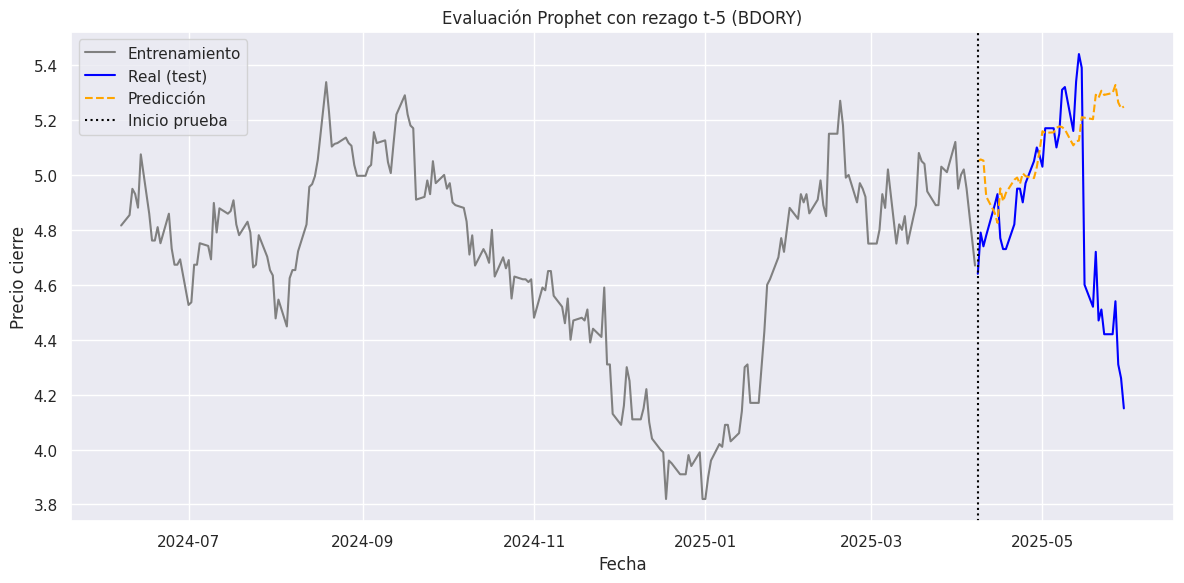

Métricas del modelo Prophet con rezago t-5:
• MAE: 0.3251
• RMSE: 0.4657
• MAPE: 7.13%
• R² Score: -1.0440


In [27]:
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1. Crear y preparar el dataset
df_prophet = df_yfinance[['close_BDORY', 'close_BVSP']].dropna().copy()
df_prophet = df_prophet.reset_index().rename(columns={'Date': 'ds', 'close_BDORY': 'y', 'close_BVSP': 'bvsp'})
df_prophet['bvsp_lag5'] = df_prophet['bvsp'].shift(5)
df_prophet = df_prophet.dropna().reset_index(drop=True)

# 2. Dividir en entrenamiento y prueba
cutoff = int(len(df_prophet) * 0.85)
df_train = df_prophet.iloc[:cutoff]
df_test = df_prophet.iloc[cutoff:]

# 3. Entrenar modelo Prophet con regresor rezagado
model = Prophet()
model.add_regressor('bvsp_lag5')
model.fit(df_train)

# 4. Predecir usando las fechas y regresor del test
future = df_test[['ds', 'bvsp_lag5']].copy()
forecast = model.predict(future)

# 5. Métricas de evaluación
y_true = df_test['y'].values
y_pred = forecast['yhat'].values

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mape = np.mean(np.abs((y_true - y_pred) / np.where(y_true == 0, 1e-3, y_true))) * 100
r2 = r2_score(y_true, y_pred)

# 6. Gráfico comparativo
plt.figure(figsize=(12, 6))
plt.plot(df_train['ds'], df_train['y'], label='Entrenamiento', color='gray')
plt.plot(df_test['ds'], y_true, label='Real (test)', color='blue')
plt.plot(forecast['ds'], y_pred, label='Predicción', linestyle='--', color='orange')
plt.axvline(df_test['ds'].iloc[0], color='black', linestyle=':', label='Inicio prueba')
plt.title('Evaluación Prophet con rezago t-5 (BDORY)')
plt.xlabel('Fecha')
plt.ylabel('Precio cierre')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 7. Imprimir métricas
print("Métricas del modelo Prophet con rezago t-5:")
print(f"• MAE: {mae:.4f}")
print(f"• RMSE: {rmse:.4f}")
print(f"• MAPE: {mape:.2f}%")
print(f"• R² Score: {r2:.4f}")


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg_ug_yfs/k4qxzoc7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg_ug_yfs/ggsu09xw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54003', 'data', 'file=/tmp/tmpg_ug_yfs/k4qxzoc7.json', 'init=/tmp/tmpg_ug_yfs/ggsu09xw.json', 'output', 'file=/tmp/tmpg_ug_yfs/prophet_model6qaztryi/prophet_model-20250617202139.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:21:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:21:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


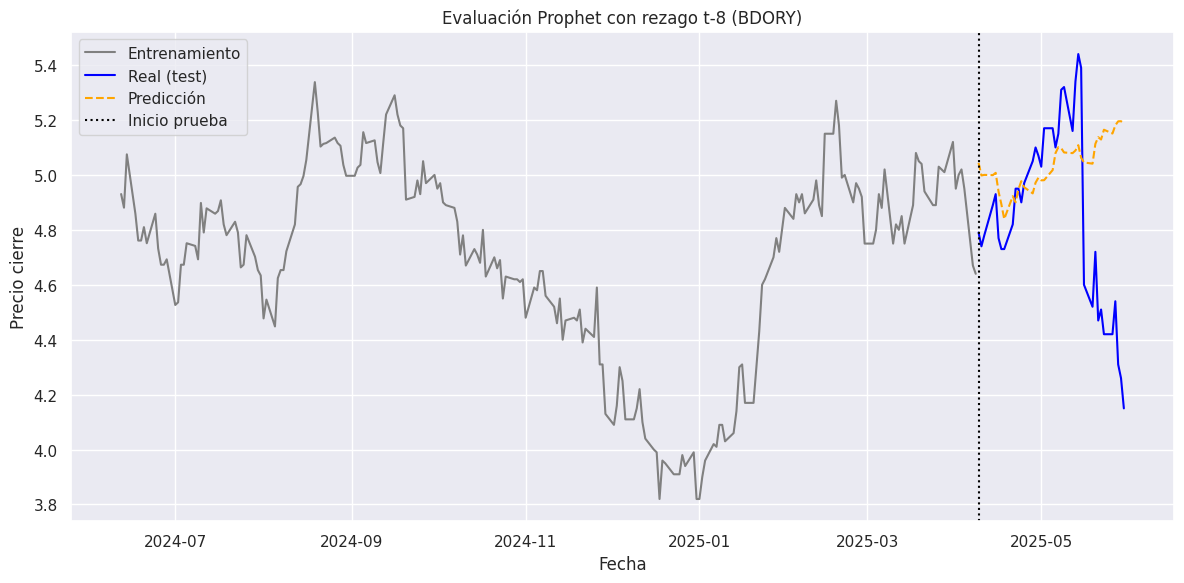

Métricas del modelo Prophet con rezago t-8:
• MAE: 0.3015
• RMSE: 0.4124
• MAPE: 6.55%
• R² Score: -0.5797


In [38]:
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1. Crear y preparar el dataset
df_prophet = df_yfinance[['close_BDORY', 'close_BVSP']].dropna().copy()
df_prophet = df_prophet.reset_index().rename(columns={'Date': 'ds', 'close_BDORY': 'y', 'close_BVSP': 'bvsp'})
df_prophet['bvsp_lag8'] = df_prophet['bvsp'].shift(8)
df_prophet = df_prophet.dropna().reset_index(drop=True)

# 2. Dividir en entrenamiento y prueba
cutoff = int(len(df_prophet) * 0.85)
df_train = df_prophet.iloc[:cutoff]
df_test = df_prophet.iloc[cutoff:]

# 3. Entrenar modelo Prophet con regresor rezagado
model = Prophet()
model.add_regressor('bvsp_lag8')
model.fit(df_train)

# 4. Predecir usando las fechas y regresor del test
future = df_test[['ds', 'bvsp_lag8']].copy()
forecast = model.predict(future)

# 5. Métricas de evaluación
y_true = df_test['y'].values
y_pred = forecast['yhat'].values

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mape = np.mean(np.abs((y_true - y_pred) / np.where(y_true == 0, 1e-3, y_true))) * 100
r2 = r2_score(y_true, y_pred)

# 6. Gráfico comparativo
plt.figure(figsize=(12, 6))
plt.plot(df_train['ds'], df_train['y'], label='Entrenamiento', color='gray')
plt.plot(df_test['ds'], y_true, label='Real (test)', color='blue')
plt.plot(forecast['ds'], y_pred, label='Predicción', linestyle='--', color='orange')
plt.axvline(df_test['ds'].iloc[0], color='black', linestyle=':', label='Inicio prueba')
plt.title('Evaluación Prophet con rezago t-8 (BDORY)')
plt.xlabel('Fecha')
plt.ylabel('Precio cierre')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 7. Imprimir métricas
print("Métricas del modelo Prophet con rezago t-8:")
print(f"• MAE: {mae:.4f}")
print(f"• RMSE: {rmse:.4f}")
print(f"• MAPE: {mape:.2f}%")
print(f"• R² Score: {r2:.4f}")

Probamos agregando regresores para intentar hacer una nueva prediccion mas

---

ajustada

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyou2z0bv/fef2ckw_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyou2z0bv/3o6kyuu9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40117', 'data', 'file=/tmp/tmpyou2z0bv/fef2ckw_.json', 'init=/tmp/tmpyou2z0bv/3o6kyuu9.json', 'output', 'file=/tmp/tmpyou2z0bv/prophet_modelfyzmrlft/prophet_model-20250618113745.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:37:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:37:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


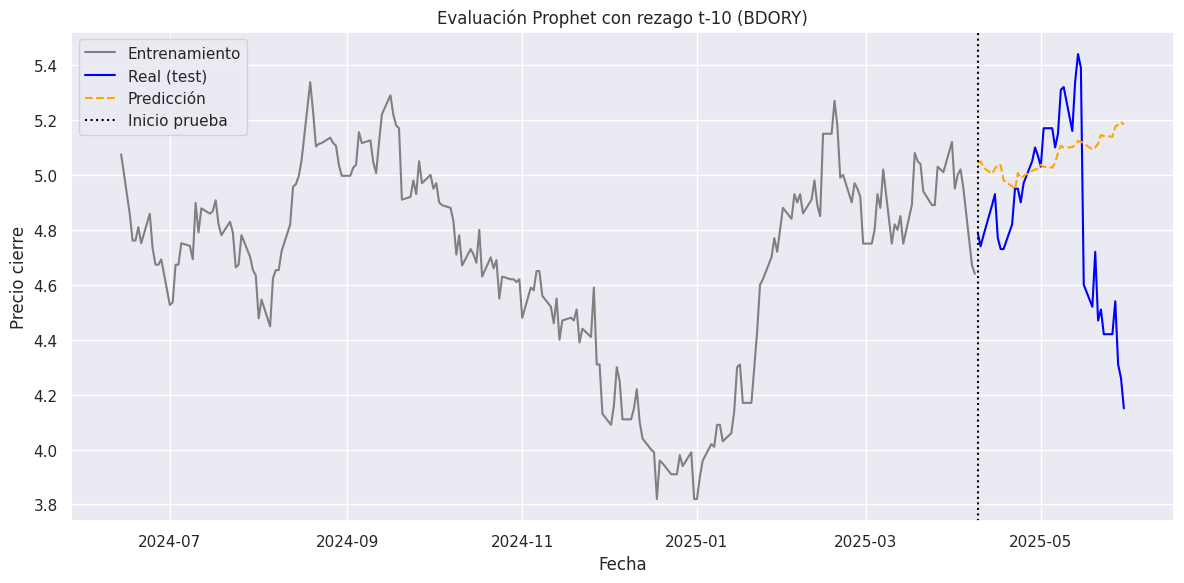

Métricas del modelo Prophet con rezago t-10:
• MAE: 0.3077
• RMSE: 0.4159
• MAPE: 6.70%
• R² Score: -0.6069


In [32]:
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1. Crear y preparar el dataset
df_prophet = df_yfinance[['close_BDORY', 'close_BVSP']].dropna().copy()
df_prophet = df_prophet.reset_index().rename(columns={'Date': 'ds', 'close_BDORY': 'y', 'close_BVSP': 'bvsp'})
df_prophet['bvsp_lag10'] = df_prophet['bvsp'].shift(10)
df_prophet = df_prophet.dropna().reset_index(drop=True)

# 2. Dividir en entrenamiento y prueba
cutoff = int(len(df_prophet) * 0.85)
df_train = df_prophet.iloc[:cutoff]
df_test = df_prophet.iloc[cutoff:]

# 3. Entrenar modelo Prophet con regresor rezagado
model = Prophet()
model.add_regressor('bvsp_lag10')
model.fit(df_train)

# 4. Predecir usando las fechas y regresor del test
future = df_test[['ds', 'bvsp_lag10']].copy()
forecast = model.predict(future)

# 5. Métricas de evaluación
y_true = df_test['y'].values
y_pred = forecast['yhat'].values

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mape = np.mean(np.abs((y_true - y_pred) / np.where(y_true == 0, 1e-3, y_true))) * 100
r2 = r2_score(y_true, y_pred)

# 6. Gráfico comparativo
plt.figure(figsize=(12, 6))
plt.plot(df_train['ds'], df_train['y'], label='Entrenamiento', color='gray')
plt.plot(df_test['ds'], y_true, label='Real (test)', color='blue')
plt.plot(forecast['ds'], y_pred, label='Predicción', linestyle='--', color='orange')
plt.axvline(df_test['ds'].iloc[0], color='black', linestyle=':', label='Inicio prueba')
plt.title('Evaluación Prophet con rezago t-10 (BDORY)')
plt.xlabel('Fecha')
plt.ylabel('Precio cierre')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 7. Imprimir métricas
print("Métricas del modelo Prophet con rezago t-10:")
print(f"• MAE: {mae:.4f}")
print(f"• RMSE: {rmse:.4f}")
print(f"• MAPE: {mape:.2f}%")
print(f"• R² Score: {r2:.4f}")

In [33]:
df_prophet.head()
df_prophet.tail()

,ds,y,bvsp,bvsp_lag10
246,2025-05-26,4.42,138136.0,136563.0
247,2025-05-27,4.54,139541.0,138963.0
248,2025-05-28,4.31,138888.0,138423.0
249,2025-05-29,4.26,138534.0,139334.0
250,2025-05-30,4.15,137027.0,139187.0


In [3]:
import yfinance as yf
import pandas as pd
import numpy as np
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# 1. Descargar datos de yfinance
stock_1 = "BDORY"
stock_2 = "^BVSP"
fecha_inicial = "2024-03-31"
fecha_final = "2025-03-31"

df_yf = yf.download(
    tickers=(stock_1, stock_2),
    start=fecha_inicial,
    end=fecha_final,
    interval="1d",
    group_by='ticker',
    auto_adjust=True
)

# 2. Crear DataFrame con regresores
df_prophet = pd.DataFrame({
    'ds': df_yf.index,
    'y': df_yf[stock_1]['Close'],
    'bvsp': df_yf[stock_2]['Close'],
    'volume_BDORY': df_yf[stock_1]['Volume']
})

# 3. Agregar regresores adicionales
df_prophet['bvsp_lag5'] = df_prophet['bvsp'].shift(5)
df_prophet['ma5'] = df_prophet['bvsp'].rolling(5).mean()
df_prophet['vol5'] = df_prophet['bvsp'].rolling(5).std()
df_prophet['volume_lag1'] = df_prophet['volume_BDORY'].shift(1)

# 4. Limpiar datos
df_prophet = df_prophet.dropna().reset_index(drop=True)
df_prophet.head()
df_prophet.tail()


[*********************100%***********************]  2 of 2 completed


,ds,y,bvsp,volume_BDORY,bvsp_lag5,ma5,vol5,volume_lag1
194,2025-03-24,4.89,131321.0,202100.0,130834.0,131920.8,520.676675,220800.0
195,2025-03-25,4.89,132068.0,107800.0,131475.0,132039.4,457.443221,202100.0
196,2025-03-26,5.03,132520.0,133000.0,132508.0,132041.8,460.537403,107800.0
197,2025-03-27,5.02,133149.0,416600.0,131955.0,132280.6,667.384672,133000.0
198,2025-03-28,5.01,131902.0,259700.0,132345.0,132192.0,685.848015,416600.0


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqxzfwr2l/_mv70gpa.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqxzfwr2l/smy0sjtf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66996', 'data', 'file=/tmp/tmpqxzfwr2l/_mv70gpa.json', 'init=/tmp/tmpqxzfwr2l/smy0sjtf.json', 'output', 'file=/tmp/tmpqxzfwr2l/prophet_modeljrt5ugt5/prophet_model-20250618014851.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:48:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:48:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


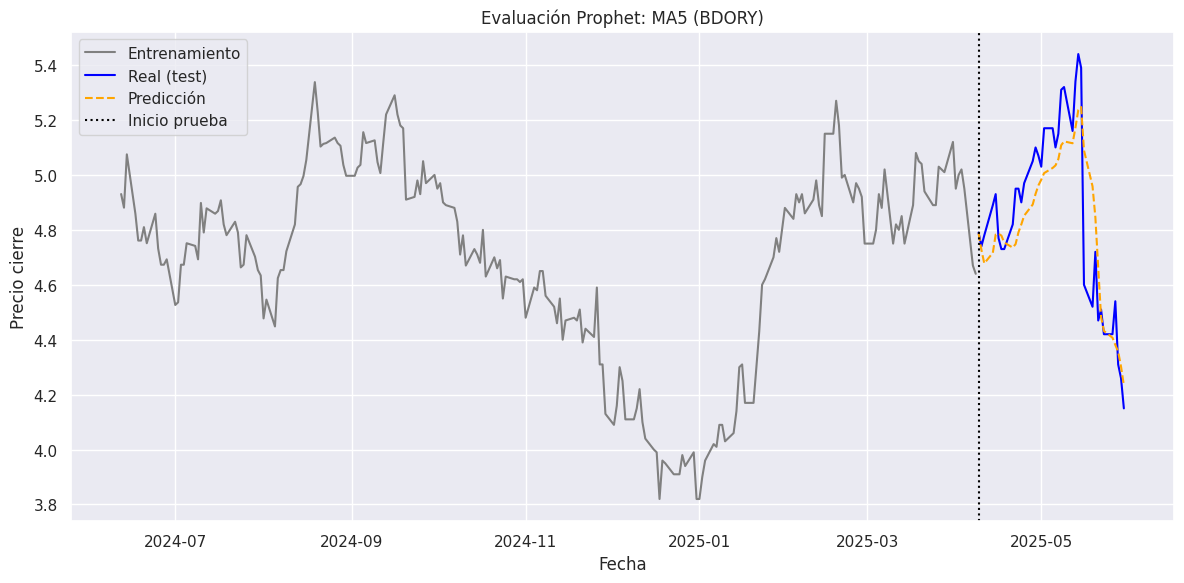

Métricas del modelo Prophet MA5:
• MAE: 0.1239
• RMSE: 0.1607
• MAPE: 2.54%
• R² Score: 0.7602


In [29]:
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1. Crear y preparar el dataset
df_prophet = df_yfinance[['close_BDORY', 'close_BVSP']].dropna().copy()
df_prophet = df_prophet.reset_index().rename(columns={'Date': 'ds', 'close_BDORY': 'y', 'close_BVSP': 'bvsp'})
df_prophet['bvsp_lag8'] = df_prophet['bvsp'].shift(8)
df_prophet['ma5'] = df_prophet['y'].rolling(window=5).mean()

# Eliminar filas con NaN causadas por el rolling y el shift
df_prophet = df_prophet.dropna().reset_index(drop=True)

# 2. Dividir en entrenamiento y prueba
cutoff = int(len(df_prophet) * 0.85)
df_train = df_prophet.iloc[:cutoff]
df_test = df_prophet.iloc[cutoff:]

# 3. Entrenar modelo Prophet con regresores
model = Prophet()
# model.add_regressor('bvsp_lag8')
model.add_regressor('ma5')
model.fit(df_train)

# 4. Predecir usando las fechas y regresores del test
future = df_test[['ds', 'bvsp_lag8', 'ma5']].copy()
forecast = model.predict(future)

# 5. Métricas de evaluación
y_true = df_test['y'].values
y_pred = forecast['yhat'].values

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mape = np.mean(np.abs((y_true - y_pred) / np.where(y_true == 0, 1e-3, y_true))) * 100
r2 = r2_score(y_true, y_pred)

# 6. Gráfico comparativo
plt.figure(figsize=(12, 6))
plt.plot(df_train['ds'], df_train['y'], label='Entrenamiento', color='gray')
plt.plot(df_test['ds'], y_true, label='Real (test)', color='blue')
plt.plot(forecast['ds'], y_pred, label='Predicción', linestyle='--', color='orange')
plt.axvline(df_test['ds'].iloc[0], color='black', linestyle=':', label='Inicio prueba')
plt.title('Evaluación Prophet: MA5 (BDORY)')
plt.xlabel('Fecha')
plt.ylabel('Precio cierre')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 7. Imprimir métricas
print("Métricas del modelo Prophet MA5:")
print(f"• MAE: {mae:.4f}")
print(f"• RMSE: {rmse:.4f}")
print(f"• MAPE: {mape:.2f}%")
print(f"• R² Score: {r2:.4f}")


In [25]:
df_prophet.head()
df_prophet.tail()

,ds,y,bvsp,bvsp_ma5,bvsp_ma10,bvsp_ma20,bvsp_volatility,bvsp_rsi,bvsp_diff,bvsp_pct_change,...,bvsp_lag3,y_lag3,bvsp_lag5,y_lag5,bvsp_lag10,y_lag10,month,quarter,day_of_week,is_month_end
256,2025-05-26,4.42,138136.0,138244.8,138676.7,136842.00,908.989188,69.405242,312.0,0.002264,...,137881.0,4.47,139636.0,4.52,136563.0,5.16,5,2,0,0
257,2025-05-27,4.54,139541.0,138131.0,138734.5,137064.40,946.806944,73.284815,1405.0,0.010171,...,137273.0,4.51,140110.0,4.72,138963.0,5.34,5,2,1,0
258,2025-05-28,4.31,138888.0,138332.4,138781.0,137255.45,941.210686,62.061762,-653.0,-0.004680,...,137824.0,4.42,137881.0,4.47,138423.0,5.44,5,2,2,0
259,2025-05-29,4.26,138534.0,138584.6,138701.0,137428.80,922.803578,59.121256,-354.0,-0.002549,...,138136.0,4.42,137273.0,4.51,139334.0,5.39,5,2,3,0
260,2025-05-30,4.15,137027.0,138425.2,138485.0,137523.45,1041.559621,51.850080,-1507.0,-0.010878,...,139541.0,4.54,137824.0,4.42,139187.0,4.60,5,2,4,0


Tratamos de encontrar cual sera el rezago con el que mas convenga entrenar nuestro modelo.

Dados estos valores vemos que la mejor manera de entrenar va a ser con un resago de t-8

### Conclusión uso de Prophet